# Analyse dataset Peyser (GSE129605)

In [14]:
os.chdir('/home/h/hollenberg/masterpraktikum_fibrosis_atlas/')
os.getcwd()

'/home/h/hollenberg/masterpraktikum_fibrosis_atlas'

In [76]:
import scanpy as sc
import os
import gzip
import shutil
from tqdm.notebook import tqdm
import anndata
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation
#import anndata2ri
import logging
import pandas as pd
import source.utils as utils
from tqdm.autonotebook import tqdm
import scrublet

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
plt.rcParams['figure.figsize'] = (9, 9)

## Load and Merge raw data

In [23]:
path = "/home/h/hollenberg/MaPra/GSE129605"

In [24]:
adata_raw = {}
for folder in tqdm(os.listdir(path)):
    adata_raw[folder] = sc.read_10x_mtx(os.path.join(path, folder))


100%|███████████████████████████████████████████| 11/11 [00:51<00:00,  4.66s/it]


In [25]:
adata_raw = anndata.concat(adata_raw, label="samples")

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [26]:
adata_raw.obs[['GSM', 'tmp']] = adata_raw.obs['samples'].str.split("_", expand = True)
adata_raw.obs[['condition', 'id']] = adata_raw.obs['tmp'].str.split(".", expand = True)
adata_raw.obs.drop(columns=['tmp'], inplace=True)
adata_raw.obs

samples         GSM   condition  \
AAACCTGAGGCTAGGT-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACCTGTCGAATCCA-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACGGGCACGAAACG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACGGGGTGGTGTAG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACGGGTCGGCTACG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
...                                          ...         ...         ...   
TTTGCGCAGCTCAACT-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGCGCCAGTCACTA-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGCGCCATTTGCCC-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGTCACAGGGTATG-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGTCATCTAACTGG-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   

                        id  
AAACCTGAGGCTAGGT-1  947178  
AAACCTGTCGAATCCA-1  947178  
AAACGGGCACGAAACG-1  947178  
AAACGGGGTGGTGTAG-1  947178  
AAACGGGTCGGCTACG-1  947178  
...                    ...  
TTTGCGCAGCTCAACT-1  947177  
TTTGCGCCAGTCACTA-1  947177  
TTTGCGCCATTTGCCC-1  947177  
TTTGTCACAGGGTATG-1  947177  
TTTGTCATCTAACTGG-1  947177  

[18975 rows x 4 columns]

### Quality Control

In [27]:
adata_raw.var_names_make_unique()
adata_raw.obs_names_make_unique()
adata_raw

AnnData object with n_obs × n_vars = 18975 × 25127
    obs: 'samples', 'GSM', 'condition', 'id'

In [54]:
# mitochondrial genes
adata_raw.var["mt"] = adata_raw.var_names.str.startswith(("MT-", "mt-", "Mt-"))
# ribosomal genes
adata_raw.var["ribo"] = adata_raw.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes.
adata_raw.var["hb"] = adata_raw.var_names.str.contains(("^HB[^(P)]|^hb[^(p)]|^Hb[^(p)]"))


print(adata_raw.var["mt"].value_counts())
print(adata_raw.var["ribo"].value_counts())
print(adata_raw.var["hb"].value_counts())

mt
False    25127
Name: count, dtype: int64
ribo
False    25022
True       105
Name: count, dtype: int64
hb
False    25115
True        12
Name: count, dtype: int64


In [55]:
sc.pp.calculate_qc_metrics(
    adata_raw, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
#adata_raw

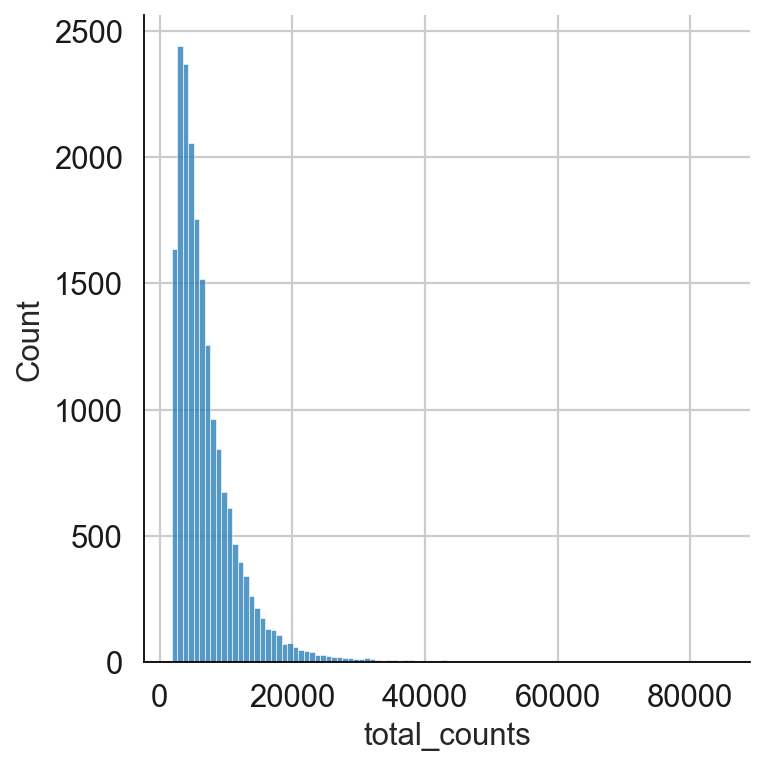

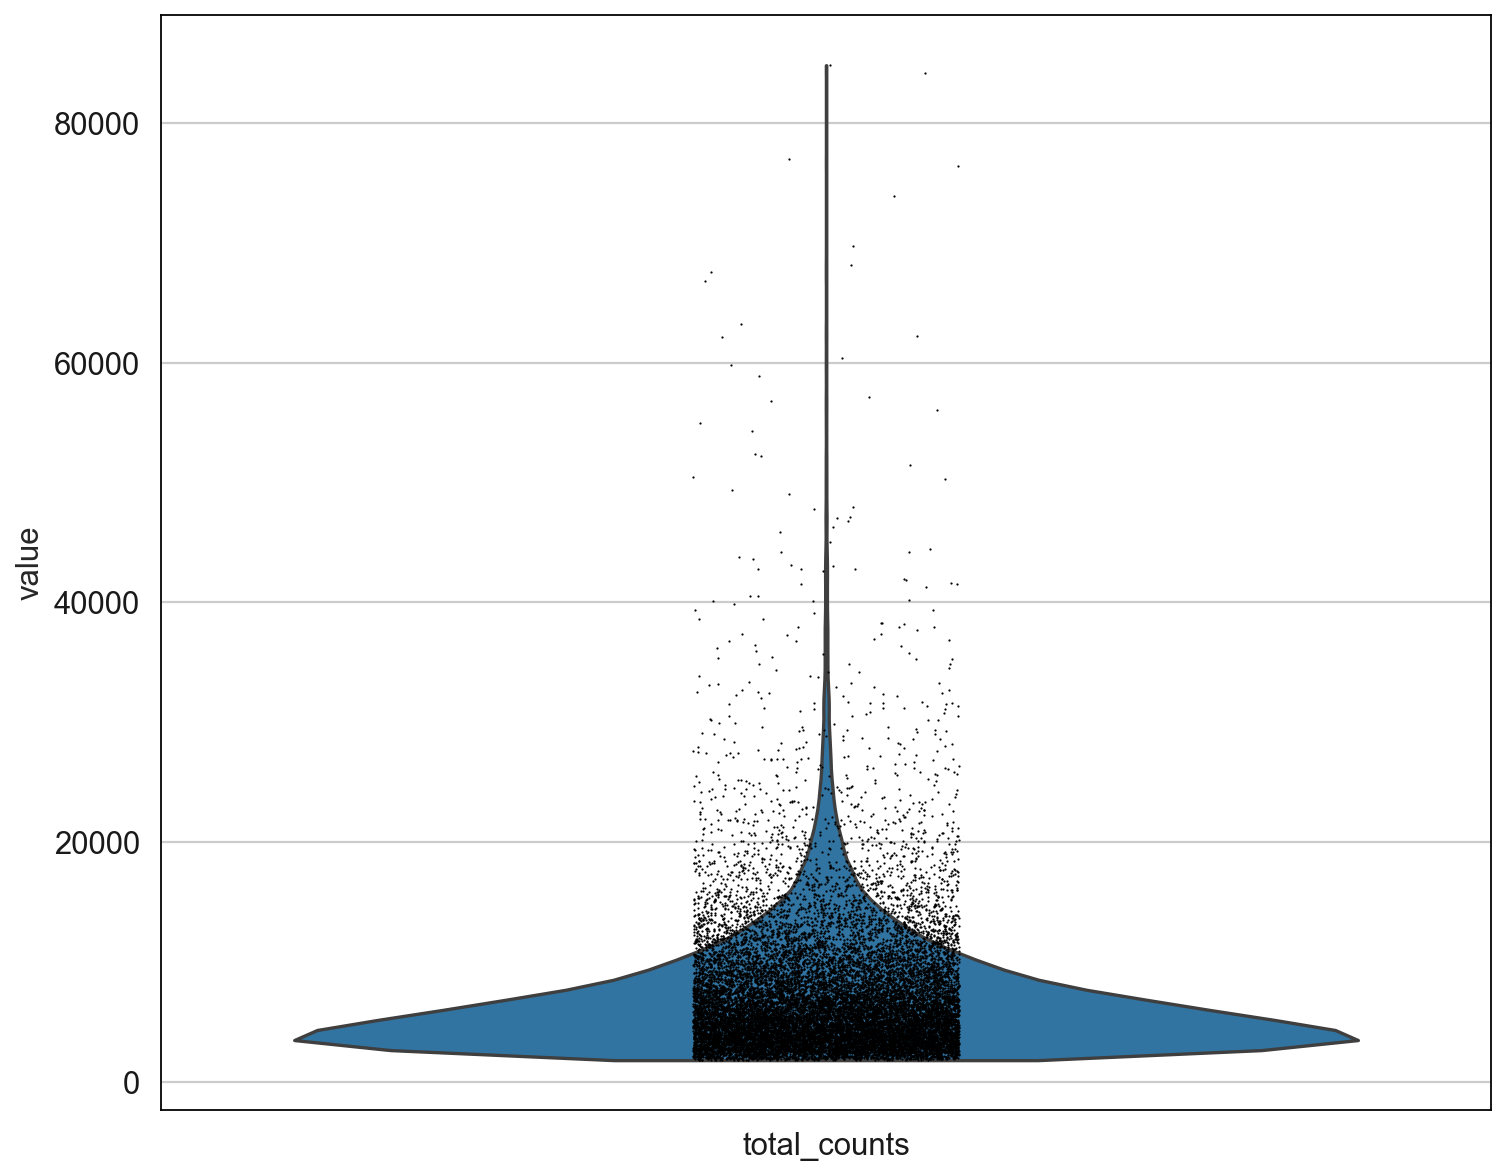

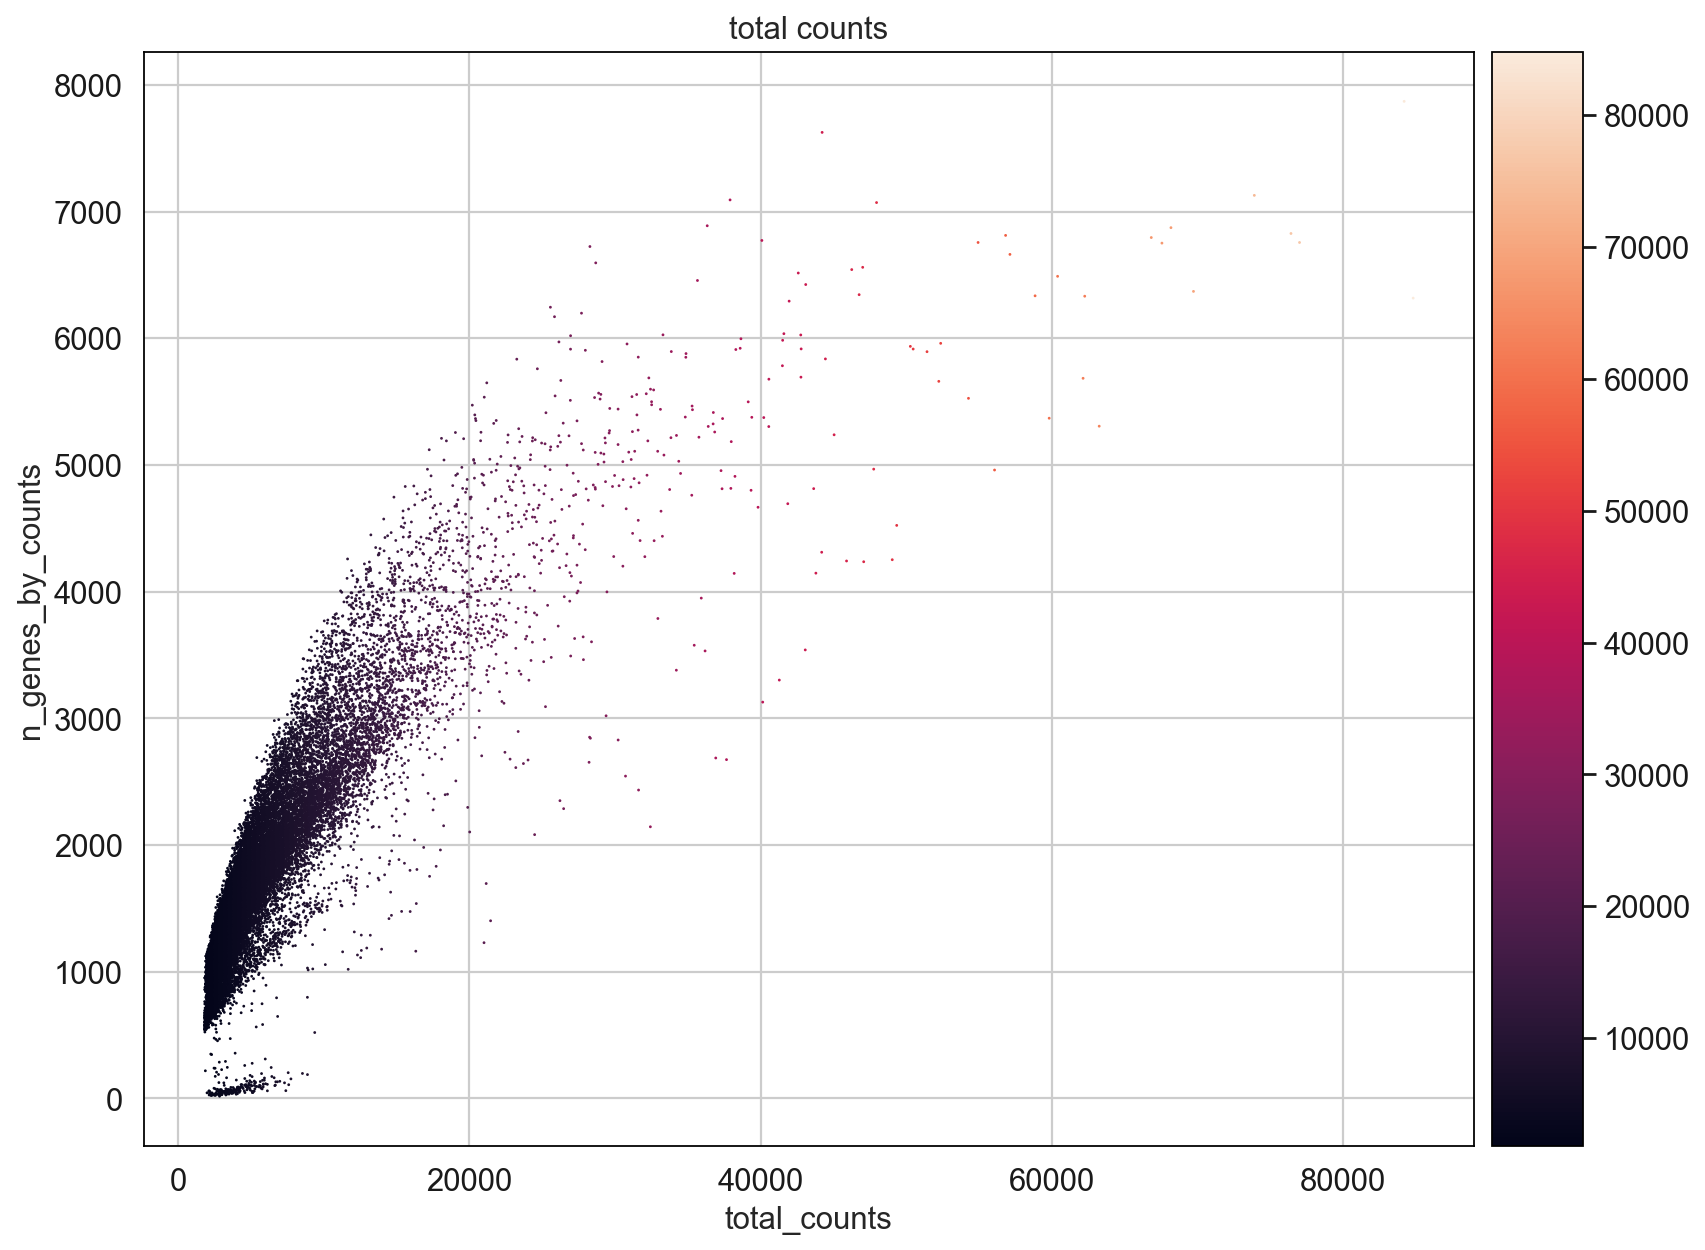

In [56]:
p1 = sns.displot(adata_raw.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata_raw, 'total_counts')
#p2 = sc.pl.violin(adata_raw, "pct_counts_mt")
p3 = sc.pl.scatter(adata_raw, "total_counts", "n_genes_by_counts", color="total_counts")

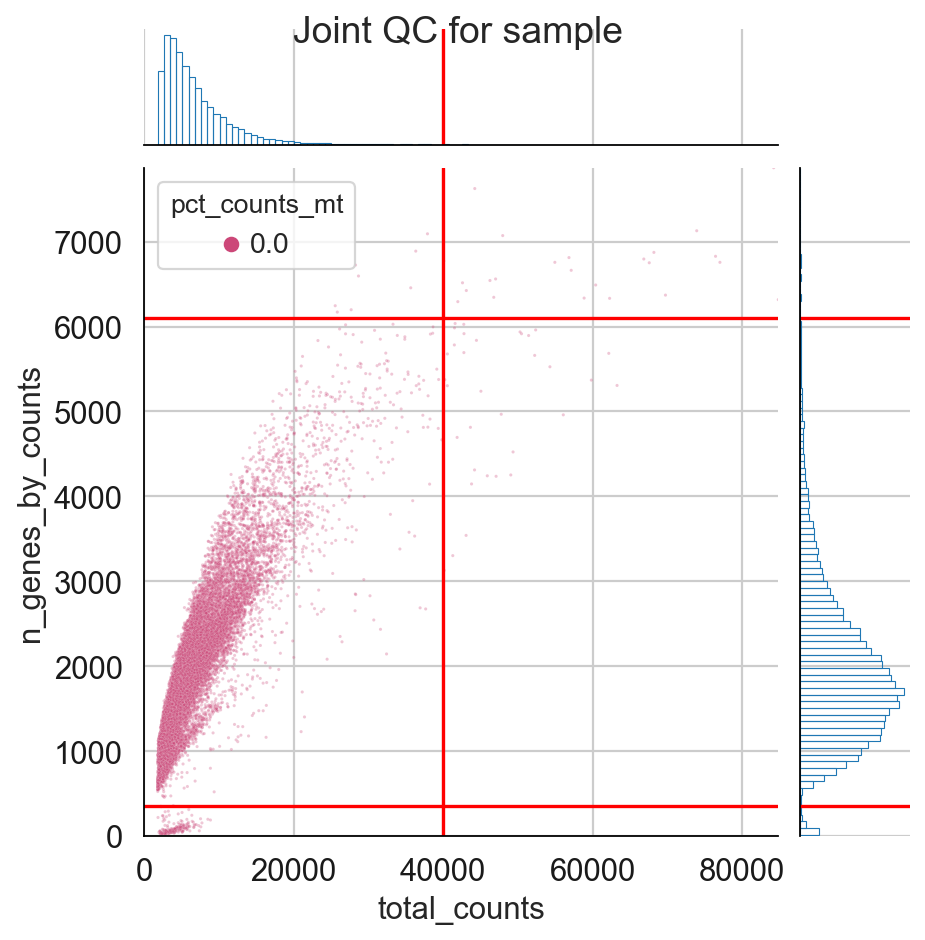

In [59]:
utils.plot_qc_joint(adata_raw, x="total_counts",
                    y='n_genes_by_counts',
                    hue='pct_counts_mt',
                    palette='plasma',
                    x_threshold=(350, 6100),   # total_counts
                    y_threshold=(0, 40000),    # n_genes_by_counts
                    title='Joint QC for sample ')

In [60]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [61]:
adata_raw.obs["outlier"] = (
    is_outlier(adata_raw, "log1p_total_counts", 5)
    | is_outlier(adata_raw, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_raw, "pct_counts_in_top_20_genes", 5)
)
adata_raw.obs.outlier.value_counts()

outlier
False    17556
True      1419
Name: count, dtype: int64

In [62]:
adata_raw.obs["mt_outlier"] = is_outlier(adata_raw, "pct_counts_mt", 3) | (
    adata_raw.obs["pct_counts_mt"] > 8
)
adata_raw.obs.mt_outlier.value_counts()

mt_outlier
False    18975
Name: count, dtype: int64

In [63]:
print(f"Total number of cells: {adata_raw.n_obs}")
adata_raw = adata_raw[(~adata_raw.obs.outlier) & (~adata_raw.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata_raw.n_obs}")

Total number of cells: 18975
Number of cells after filtering of low quality cells: 17556


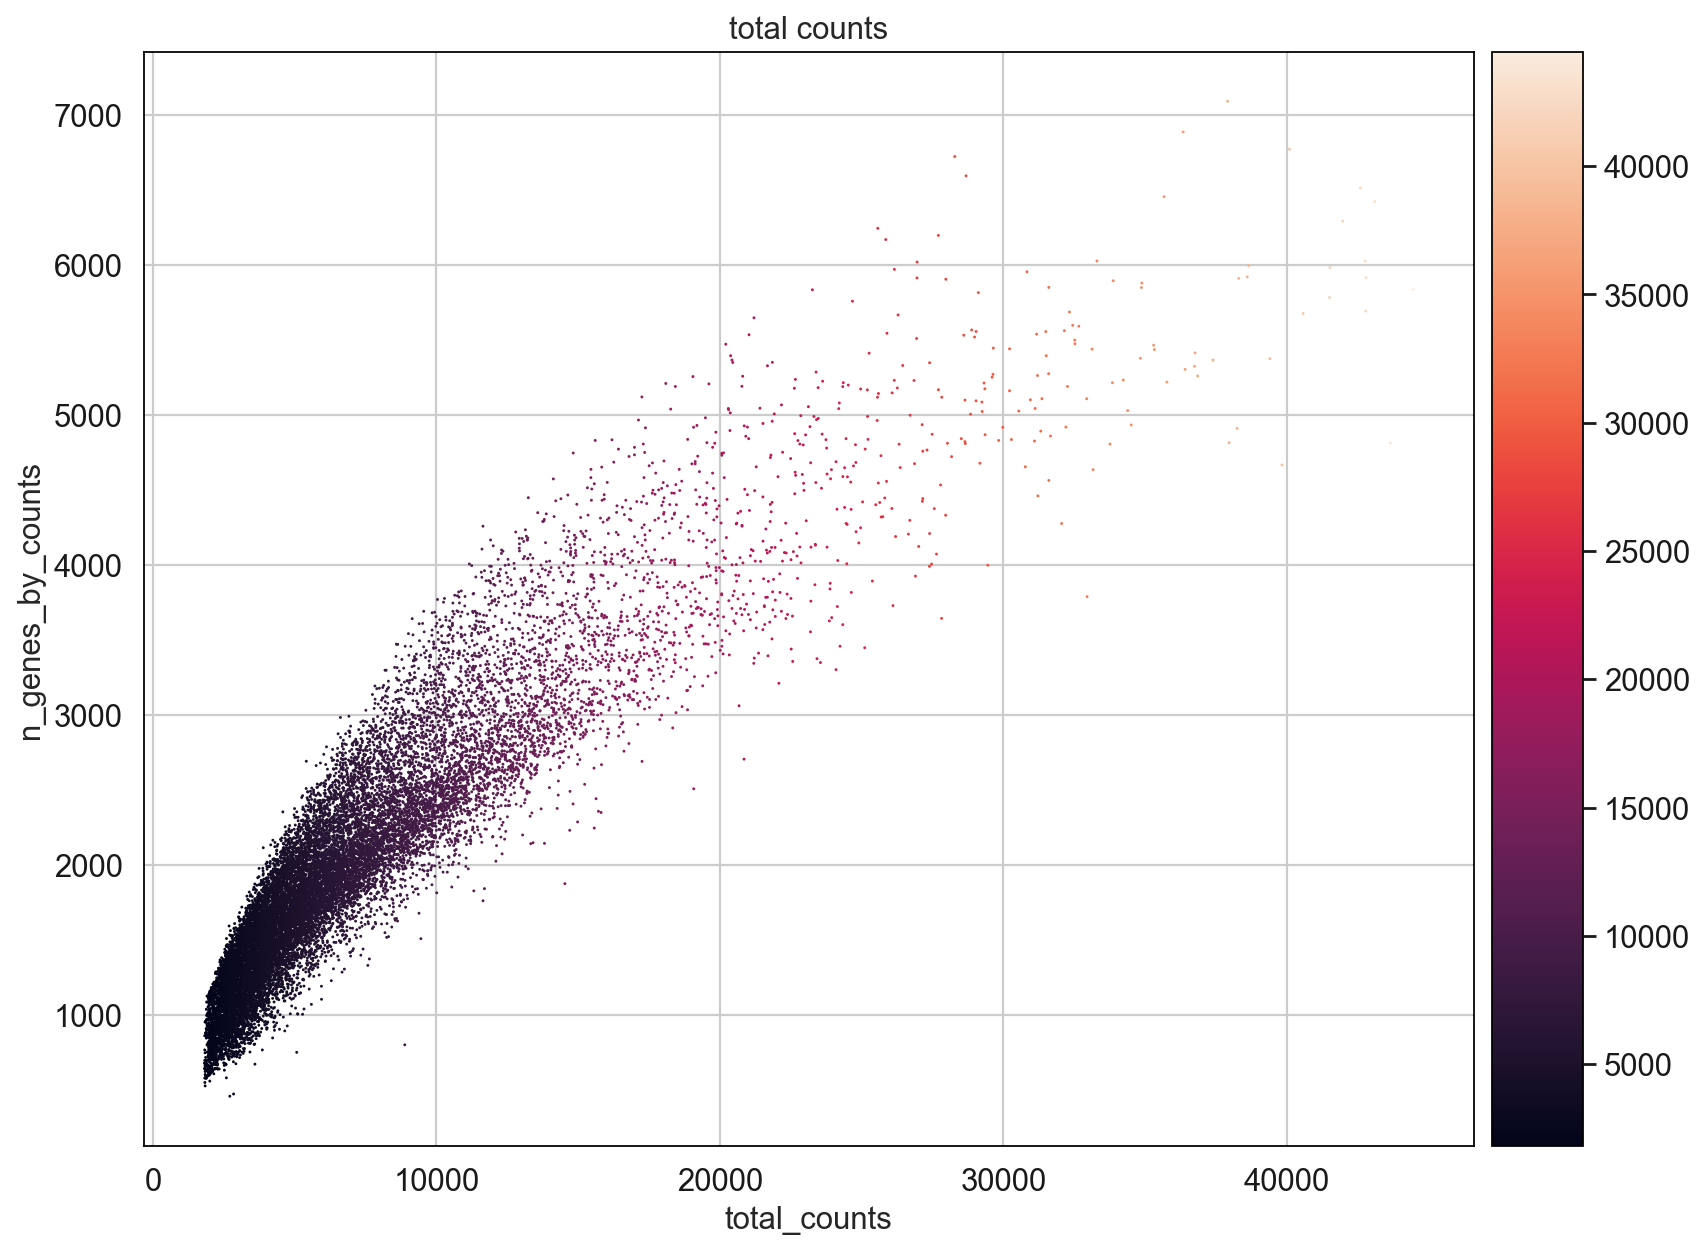

In [64]:
p1 = sc.pl.scatter(adata_raw, "total_counts", "n_genes_by_counts", color="total_counts")

### Normalization

In [65]:
scales_counts = sc.pp.normalize_total(adata_raw, target_sum=None, inplace=False)
# log1p transform
adata_raw.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata_raw.X = adata_raw.layers['log1p_norm']

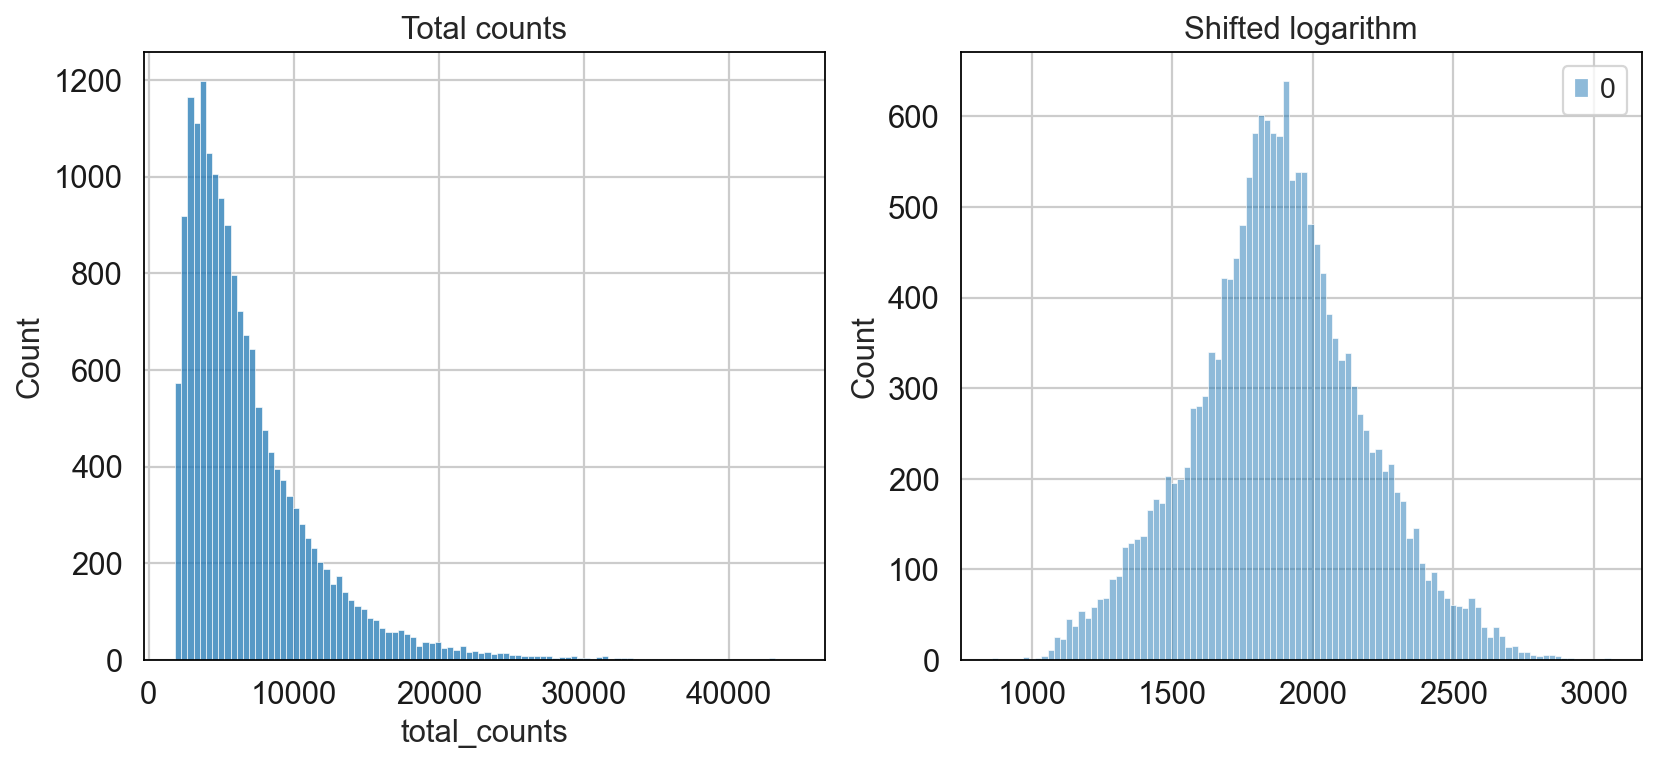

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
p1 = sns.histplot(adata_raw.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata_raw.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### Feature Selection

In [67]:
print("Number of genes in data before filtering: ", adata_raw.n_vars)
print("Number of cells in data before filtering: ", adata_raw.n_obs)

sc.pp.filter_cells(adata_raw, min_genes=350)
sc.pp.filter_cells(adata_raw, max_genes=6100)
sc.pp.filter_cells(adata_raw, max_counts=40000)
sc.pp.filter_genes(adata_raw, min_counts=1)

print("Number of genes in filtered data: ", adata_raw.n_vars)
print("Number of cells in filtered data: ", adata_raw.n_obs)

Number of genes in data before filtering:  25127
Number of cells in data before filtering:  17556
Number of genes in filtered data:  18252
Number of cells in filtered data:  17544


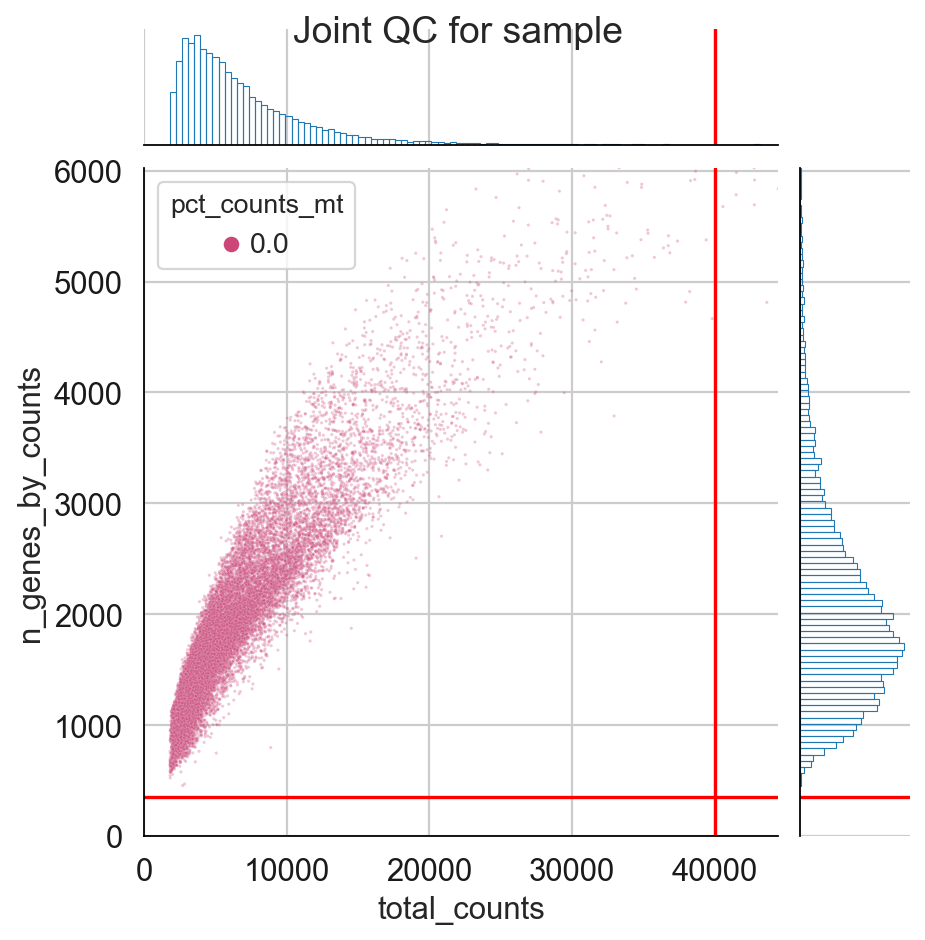

In [68]:
# plot after selection
utils.plot_qc_joint(adata_raw, x="total_counts",
                    y='n_genes_by_counts',
                    hue='pct_counts_mt',
                    palette='plasma',
                    x_threshold=(350, 6100),  # total_counts
                    y_threshold=(0, 40000),  # n_genes_by_counts
                    title='Joint QC for sample ')

In [69]:
adata_raw.write("/home/h/hollenberg/MaPra/adata_processed_lea.h5ad")

In [70]:
adata = sc.read("/home/h/hollenberg/MaPra/adata_processed_lea.h5ad")

### Dimensionality Reduction

In [71]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/si

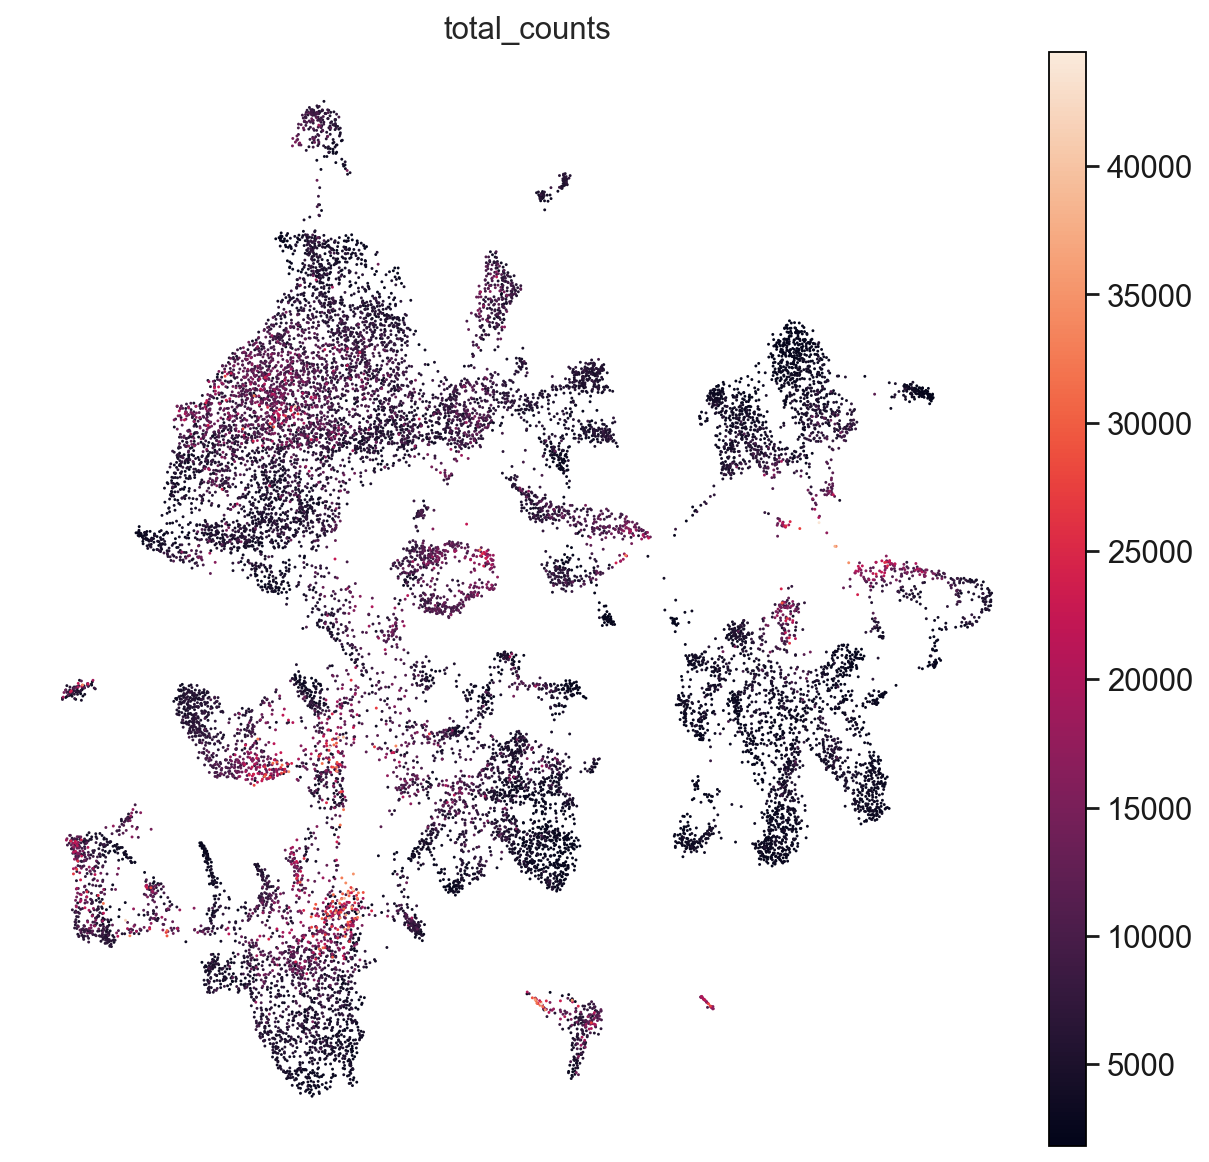

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


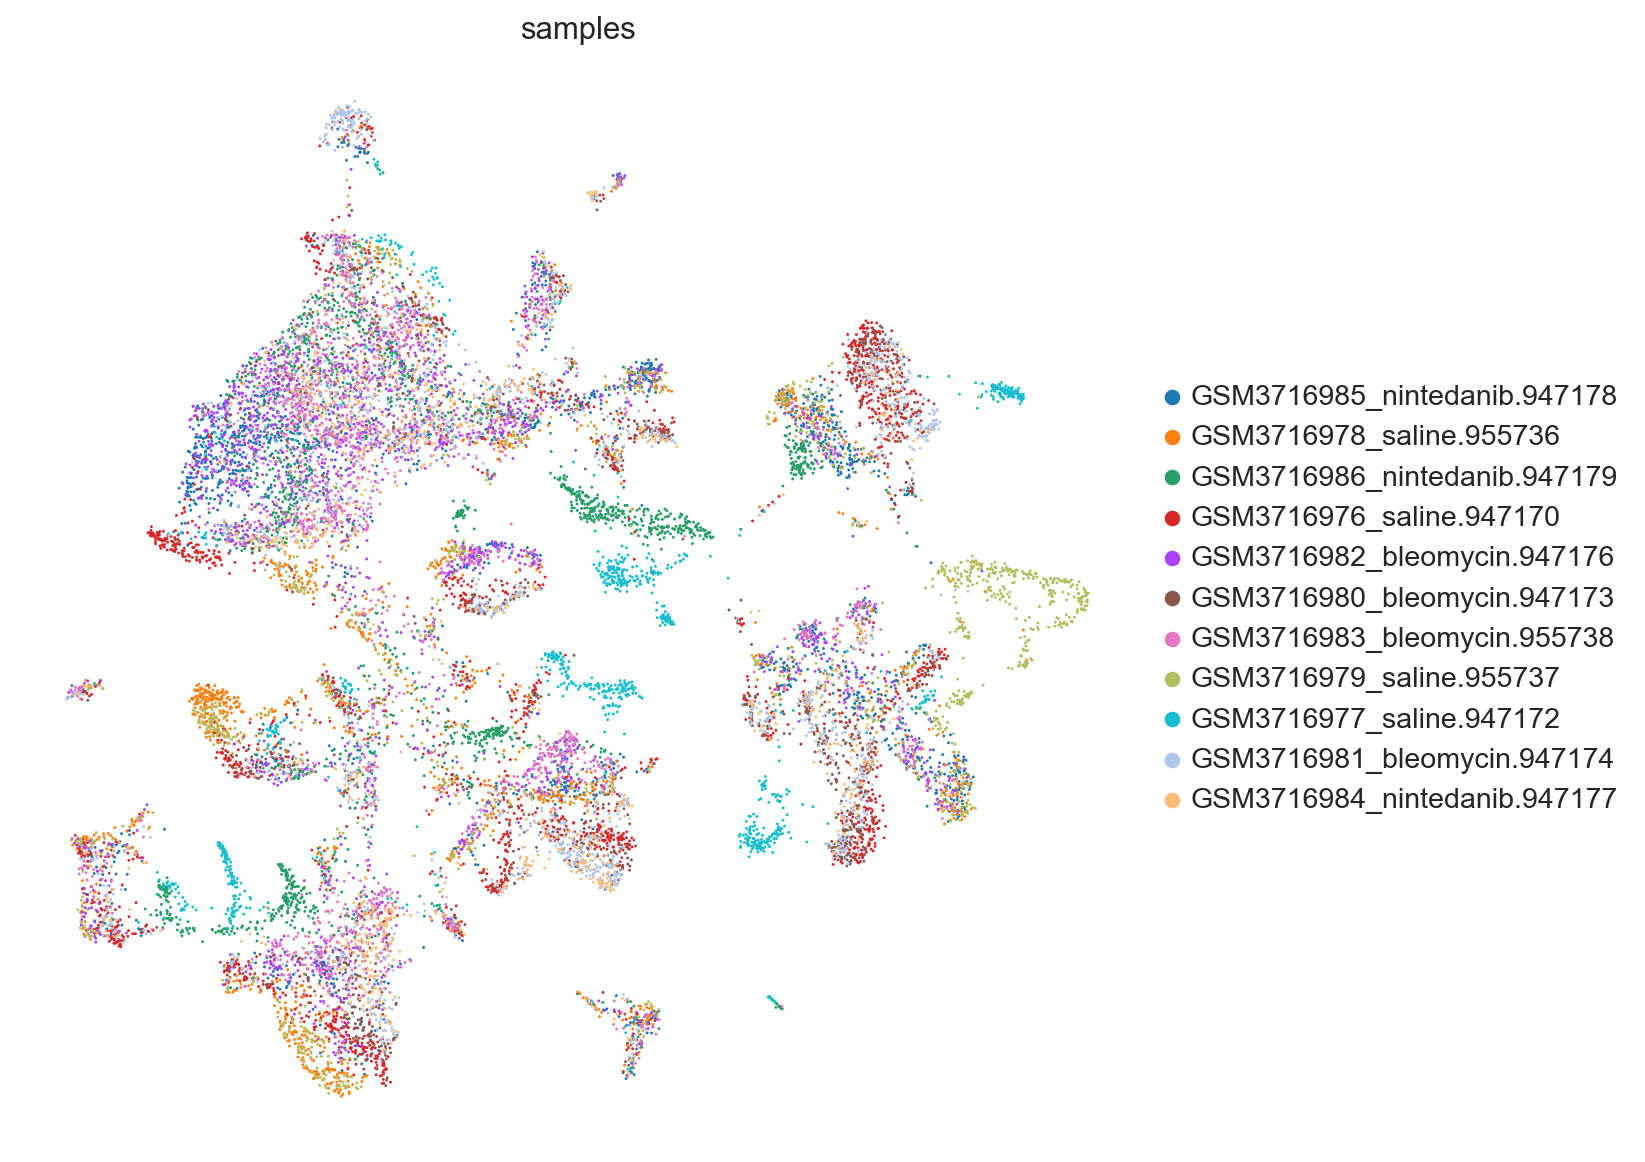

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


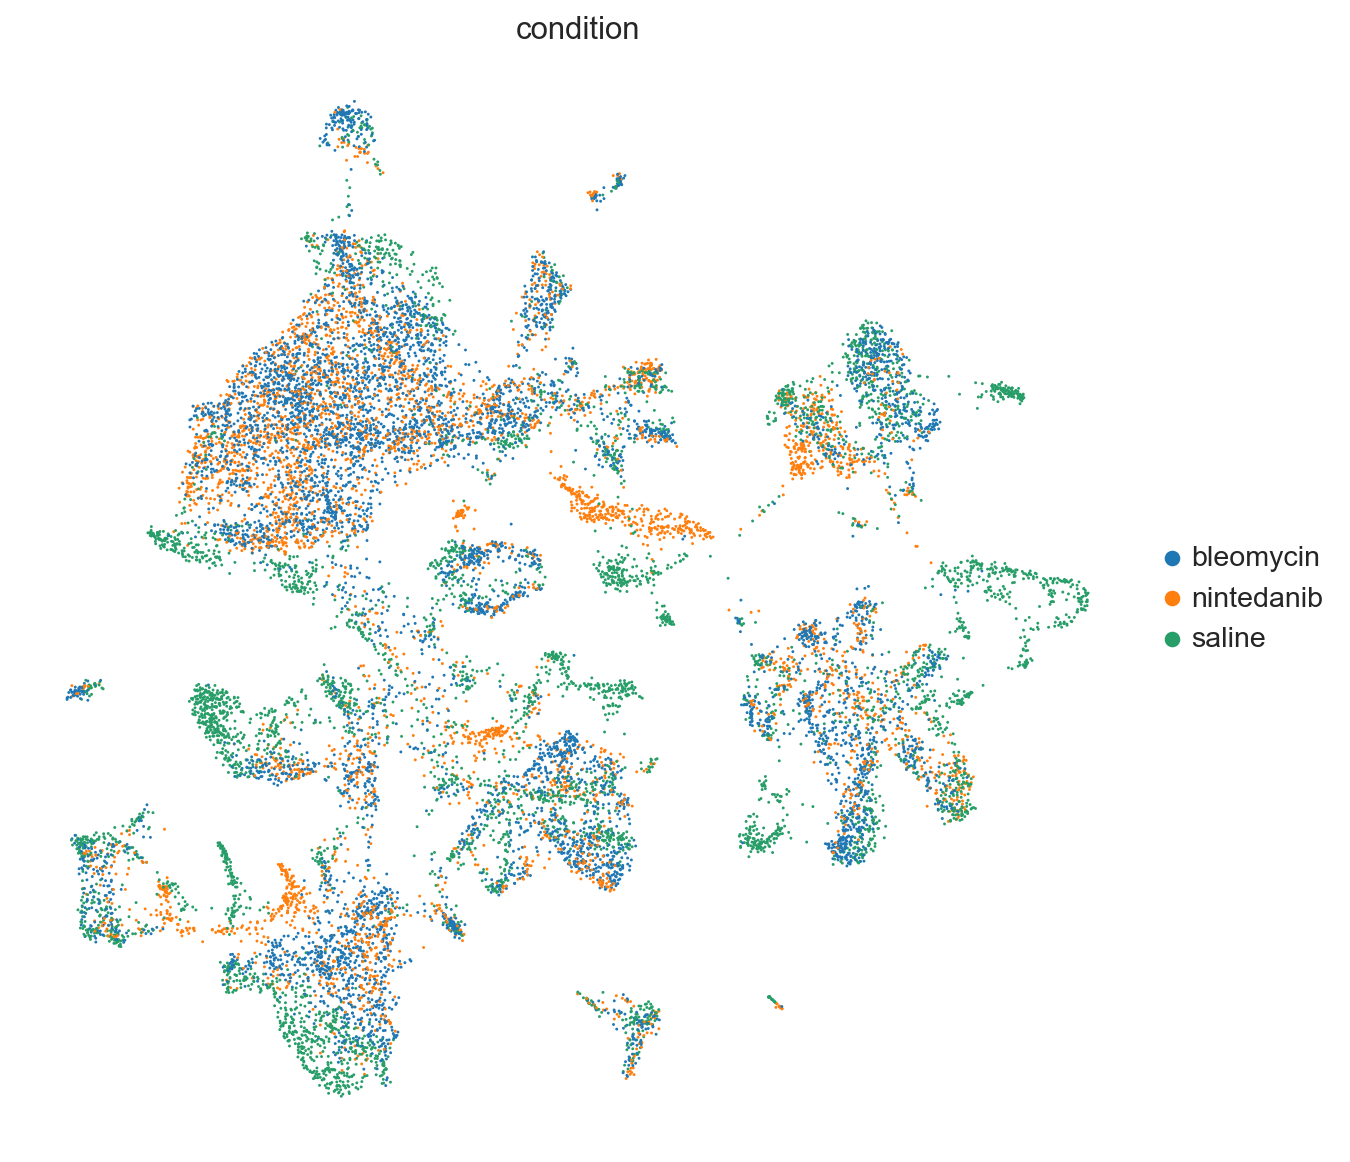

In [72]:
sc.pl.umap(adata=adata, color=["total_counts"])
sc.pl.umap(adata=adata, color=["samples"])
sc.pl.umap(adata=adata, color=["condition"])

### Doublet-Detektion

In [77]:
sc.external.pp.scrublet(adata)
doublet_scores = adata.obs['predicted_doublet']
threshold = 0.5
adata.obs['is_doublet'] = doublet_scores > threshold

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 3.0%
Estimated detectable doublet fraction = 70.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.2%


In [78]:
adata.obs['is_doublet'] = adata.obs['is_doublet'].astype(str)
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype(str)
adata.obs

samples         GSM   condition  \
AAACCTGAGGCTAGGT-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACCTGTCGAATCCA-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACGGGCACGAAACG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACGGGGTGGTGTAG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
AAACGGGTCGGCTACG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
...                                          ...         ...         ...   
TTTCCTCTCTGCGACG-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGCGCAGCTCAACT-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGCGCCATTTGCCC-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGTCACAGGGTATG-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   
TTTGTCATCTAACTGG-1  GSM3716984_nintedanib.947177  GSM3716984  nintedanib   

                        id  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGGCTAGGT-1  947178               1303                 7.173192   
AAACCTGTCGAATCCA-1  947178               1811                 7.502186   
AAACGGGCACGAAACG-1  947178               1549                 7.346010   
AAACGGGGTGGTGTAG-1  947178               1256                 7.136483   
AAACGGGTCGGCTACG-1  947178               2401                 7.784057   
...                    ...                ...                      ...   
TTTCCTCTCTGCGACG-1  947177               2740                 7.916078   
TTTGCGCAGCTCAACT-1  947177               1557                 7.351158   
TTTGCGCCATTTGCCC-1  947177               1786                 7.488294   
TTTGTCACAGGGTATG-1  947177               1159                 7.056175   
TTTGTCATCTAACTGG-1  947177               1014                 6.922644   

                    total_counts  log1p_total_counts  \
AAACCTGAGGCTAGGT-1        2847.0            7.954372   
AAACCTGTCGAATCCA-1        6994.0            8.852951   
AAACGGGCACGAAACG-1        3991.0            8.292048   
AAACGGGGTGGTGTAG-1        4079.0            8.313852   
AAACGGGTCGGCTACG-1        8895.0            9.093357   
...                          ...                 ...   
TTTCCTCTCTGCGACG-1        9331.0            9.141205   
TTTGCGCAGCTCAACT-1        3517.0            8.165648   
TTTGCGCCATTTGCCC-1        5914.0            8.685246   
TTTGTCACAGGGTATG-1        3428.0            8.140024   
TTTGTCATCTAACTGG-1        3297.0            8.101071   

                    pct_counts_in_top_20_genes  total_counts_mt  ...  \
AAACCTGAGGCTAGGT-1                   16.754478              0.0  ...   
AAACCTGTCGAATCCA-1                   21.547040              0.0  ...   
AAACGGGCACGAAACG-1                   16.812829              0.0  ...   
AAACGGGGTGGTGTAG-1                   21.083599              0.0  ...   
AAACGGGTCGGCTACG-1                   17.751546              0.0  ...   
...                                        ...              ...  ...   
TTTCCTCTCTGCGACG-1                   16.289787              0.0  ...   
TTTGCGCAGCTCAACT-1                   11.998863              0.0  ...   
TTTGCGCCATTTGCCC-1                   19.648292              0.0  ...   
TTTGTCACAGGGTATG-1                   22.812135              0.0  ...   
TTTGTCATCTAACTGG-1                   23.809524              0.0  ...   

                    total_counts_hb  log1p_total_counts_hb  pct_counts_hb  \
AAACCTGAGGCTAGGT-1              0.0               0.000000       0.000000   
AAACCTGTCGAATCCA-1              2.0               1.098612       0.028596   
AAACGGGCACGAAACG-1              1.0               0.693147       0.025056   
AAACGGGGTGGTGTAG-1              0.0               0.000000       0.000000   
AAACGGGTCGGCTACG-1              1.0               0.693147       0.011242   
...                             ...                    ...            ...   
TTTCCTCTCTGCGACG-1              1.0               0.693147       0.010717   
TTTGCGCAGCTCAACT-1              2.0               1.098612       0.056867   
TTTGCGCC

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


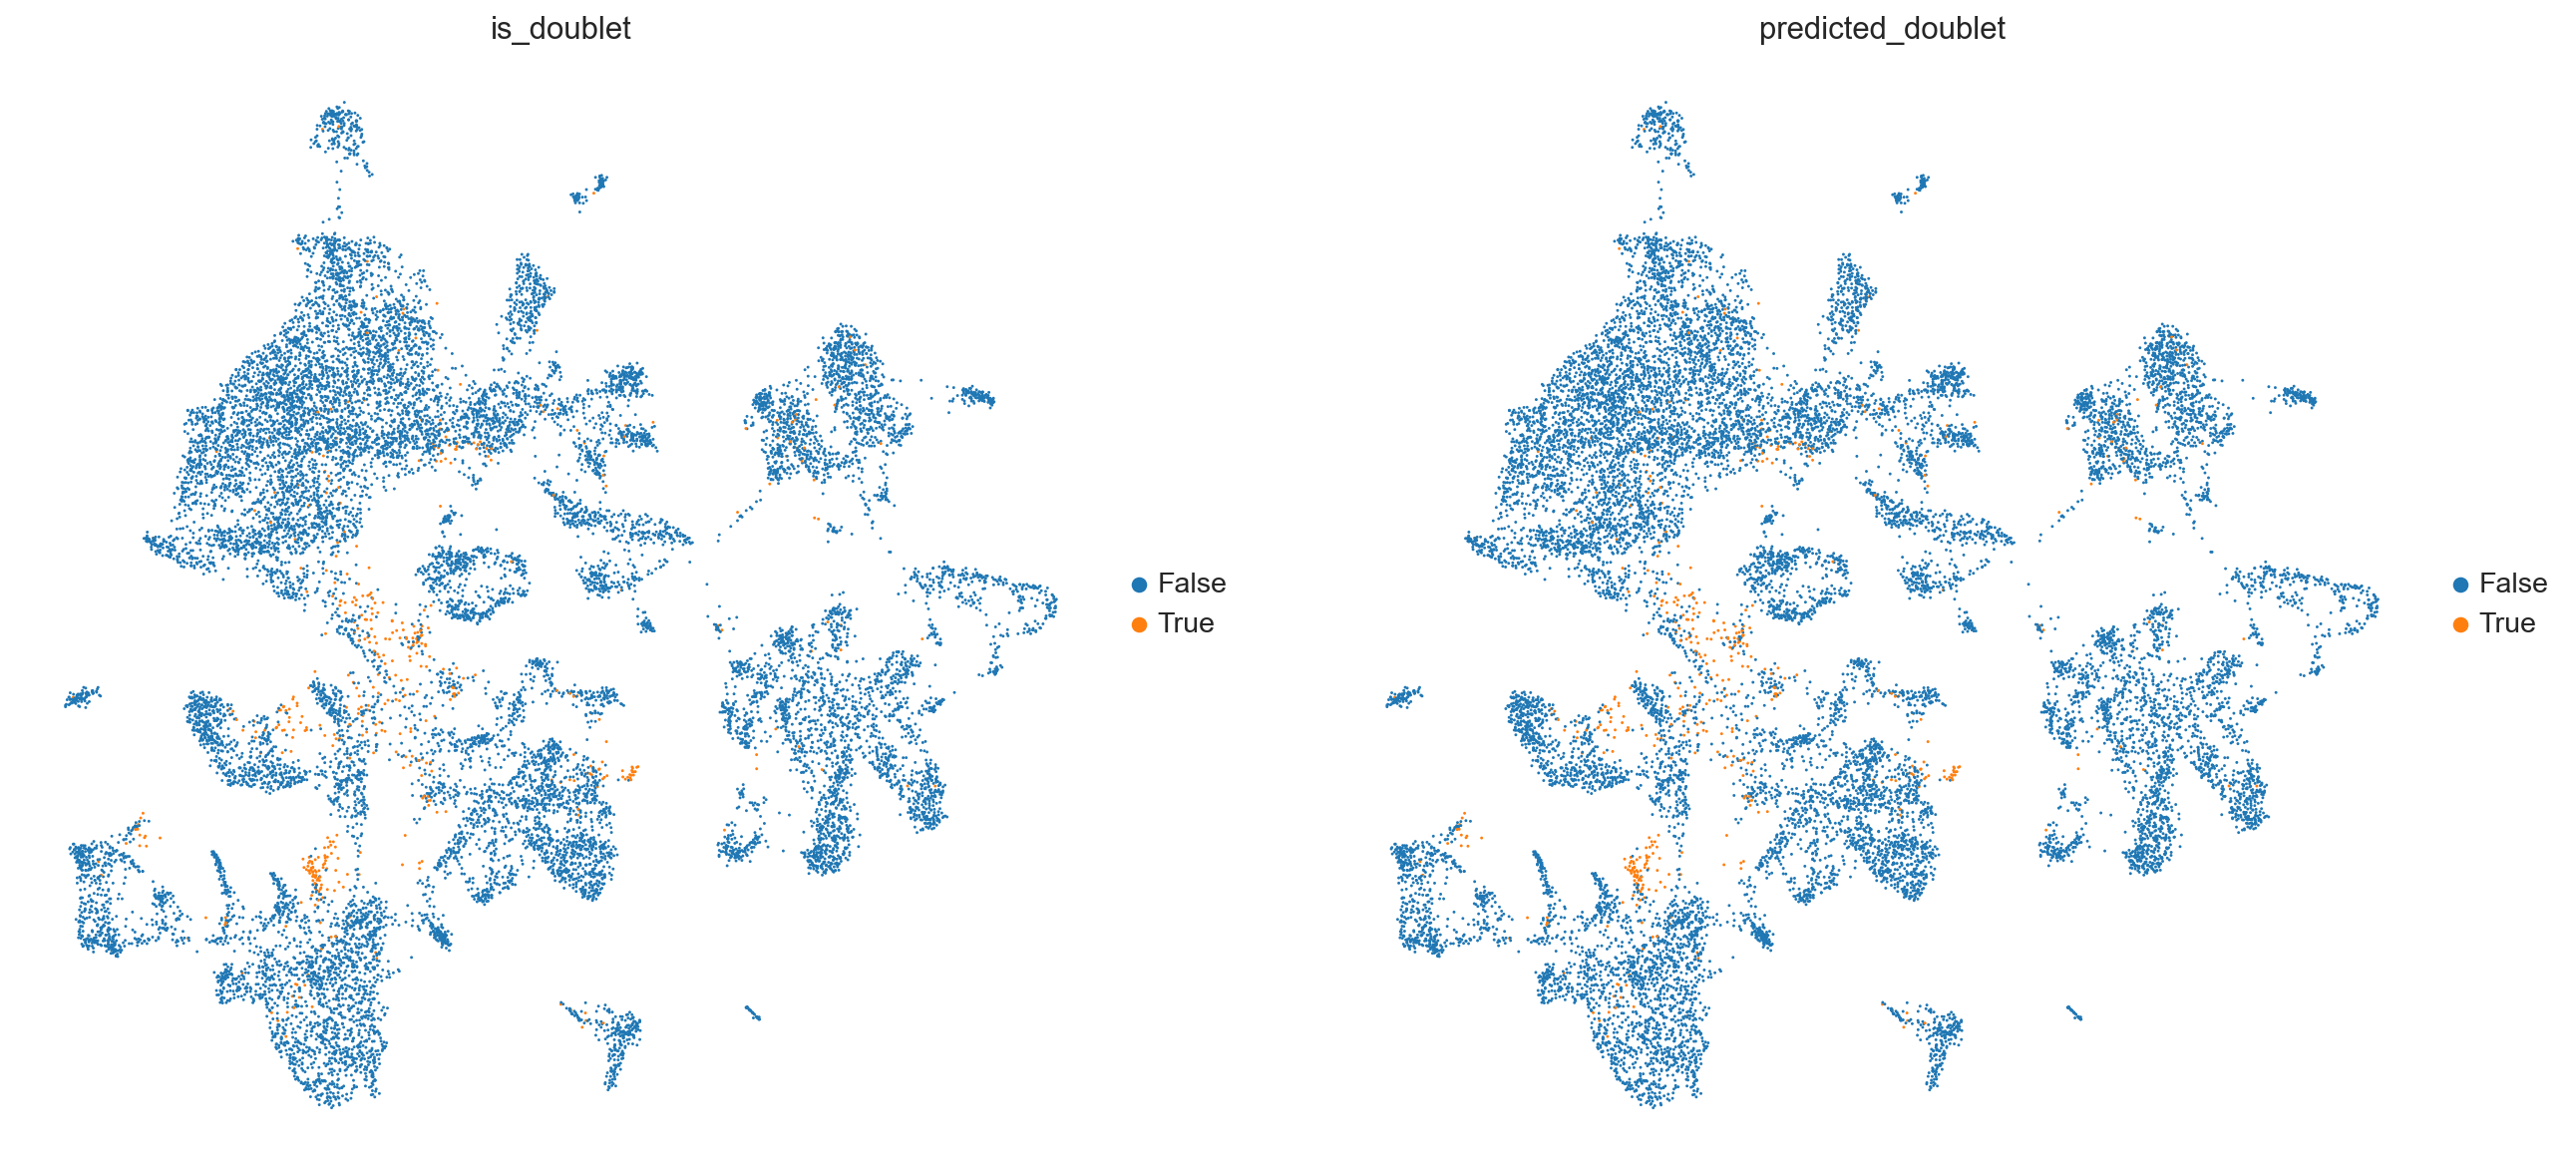

In [79]:
sc.pl.umap(adata=adata, color=["is_doublet", "predicted_doublet"])

In [81]:
adata.write("/home/h/hollenberg/MaPra/adata_processed_2_lea.h5ad")

### Quality Control Paper

- Our analysis includes the 18,435 cells and 18,025 genes passing quality-control thresholds
- average of 1,975 unique genes and 7,051 unique transcripts detected per cell.
